# CartPole Balancer using a Deep Q-Network

In [1]:
#Importing necessary libraries
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T  

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display


The class DQN is our deep-Q-network which inherits the class Module under torch.nn. The network used here is a very basic, only two fully connected layers are followed by an output layer. The number of output features will be two as the cart can only move left or right. The forward method executes a forward pass through the network. At the output layer, no activation function will be used as we want the raw values(q-values corresponding to every action).

In [3]:
class DQN(nn.Module):
    def __init__(self,img_height,img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3,out_features=24)
        self.fc2 = nn.Linear(in_features=24,out_features=32)
        self.out = nn.Linear(in_features=32,out_features=2)
    
    def forward(self,t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

We create a namedtuple to store our experiences in the replay memory.

In [4]:
Experience = namedtuple('Experience',('state','action','next_state','reward'))

In [5]:
#Example
e=Experience(2,3,1,4)
print(e)

Experience(state=2, action=3, next_state=1, reward=4)


This class ReplayMemory accepts one parameter 'capacity' while object creation. It is the size of the memory. Push count is the counter which keeps track of the number of experiences stored.

In [6]:
class ReplayMemory():
    def __init__(self,capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self,experience):
        if(len(self.memory) < self.capacity):
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count += 1
         
    def sample(self,batch_size):
        return random.sample(self.memory , batch_size)
        
        
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

The formula for exploration rate is the same as used earlier. We need an object of this class created before we create our agent

In [7]:
class EpsilonGreedyStrategy():
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self,current_step):
        return self.end + (self.start - self.end)*(math.exp(-1. * current_step * self.decay))

The Agent class initializes with the parameters - strategy(Epsilon Greedy method), num_actions(The number of available actions. 2 in our case), device(CPU/GPU, I haven't compiled torch with cuda so my code will use cpu).\
- random.random() will generate a floating point number between 0-1. If this number is less than our exploration rate then agent explores the environment else it exploits.
- torch.no_grad() - It disables gradient tracking used for back propagation as we are not training our netwrok in this step(More Info - https://stackoverflow.com/questions/56816241/difference-between-detach-and-with-torch-nograd-in-pytorch/56817594)

In [8]:
class Agent():
    def __init__(self,strategy,num_actions,device):
        self.strategy = strategy
        self.num_actions = num_actions
        self.current_step = 0
        self.device = device 
    
    def select_action(self,state,policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step+=1
        
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device)

CartPoleEnvManager
- the mode in env.render() specifies return type of the screen(More info(see render method here) - https://github.com/openai/gym/blob/master/gym/core.py)
- in get_state method, for initial and final steps in an episode, we consider a black screen ,else we consider current state as the difference between current and previous screen 
- The get_processed_screen() function gets the image data from self.render(‘rgb_array’) in the form of a height * width * number of channels dimensional Tensor. Then the .transpose( (2,0,1) ) method converts that tensor to a number of channels * height * width dimensional Tensor. The crop_screen() function collects this Tensor to crop it. Therefore screen.shape[1] is actually the height there. Later, the transform_screen_data() function uses resize(screen).unsqueeze(0) which adds an extra dimension to the tensor at the 0th position (i.e. at the start) of the size of the tensor making it a 1 * number of channels * height * width dimensional tensor. Finally, this tensor is returned by the get_processed_screen() function which explains why screen.shape[2] and screen.shape[3] are returned by the get_screen_height() and get_screen_width() functions.

In [9]:
class CartPoleEnvManager():
    def __init__(self,device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self,mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self,action):
        _, reward , self.done ,_ = self.env.step(action.item())
        return torch.tensor([reward],device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1))
        #self.close()
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self,screen):
        screen_height = screen.shape[1]
        top = int(screen_height*0.4)
        bottom = int(screen_height*0.8)
        screen = screen[:,top:bottom,:]
        return screen
    
    def transform_screen_data(self,screen):
        screen = np.ascontiguousarray(screen,dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        resize = T.Compose([T.ToPILImage(),
                            T.Resize((40,90)),
                            T.ToTensor()
                           ])
        return resize(screen).unsqueeze(0).to(self.device)
        

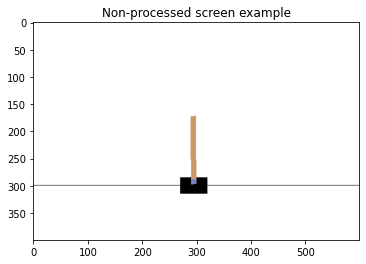

In [10]:
#Example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

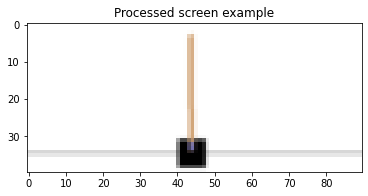

In [11]:
#Example
screen = em.get_processed_screen()
em.close()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

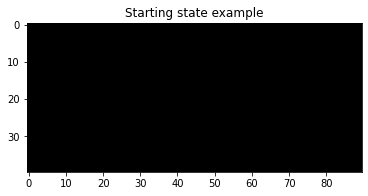

In [12]:
#Example
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


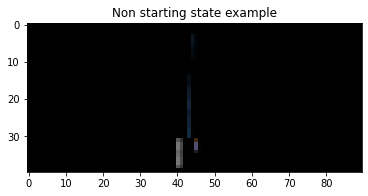

In [13]:
#Example
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

torch.Size([1, 3, 40, 90])
torch.Size([3, 40, 90])
torch.Size([40, 90, 3])


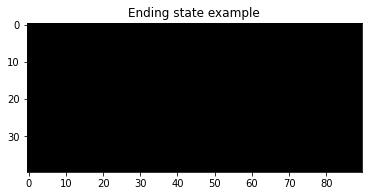

In [14]:
#Example
em.done = True
screen = em.get_state()
print(screen.shape)
print(screen.squeeze(0).shape)
print(screen.squeeze(0).permute(1, 2, 0).shape)
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

In [15]:
def plot(values,moving_avg_period):
    #print('values.shape : \n',values.shape)
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period,values) 
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values),"\n",moving_avg_period,"episode moving avg:",moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period,values):
    values=torch.tensor(values,dtype=torch.float)
    #print('values(unfold).shape : \n',values.unfold(dimension=0,size=period,step=1).shape)
    #print('values(unfold+mean).shape : \n',values.unfold(dimension=0,size=period,step=1).mean(dim=1).shape)
    #print('values(unfold+mean+flatten).shape : \n',values.unfold(dimension=0,size=period,step=1).mean(dim=1).flatten(start_dim=0).shape)
    #print('values : \n',values)
    #print('values(unfold) : \n',values.unfold(dimension=0,size=period,step=1))
    if len(values)>= period:
        moving_avg = values.unfold(dimension=0,size=period,step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1),moving_avg))
        #print('moving_avg:\n',moving_avg.shape)
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

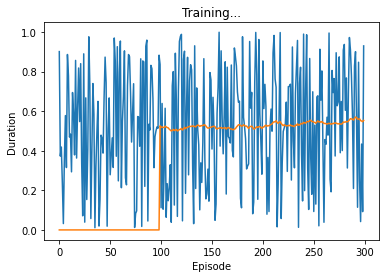

Episode 300 
 100 episode moving avg: 0.55331045


In [16]:
plot(np.random.rand(300), 100)


In [17]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    t1 =torch.cat(batch.state)
    t2 =torch.cat(batch.action)
    t3 =torch.cat(batch.reward)
    t4 =torch.cat(batch.next_state)
    return (t1,t2,t3,t4)

In [18]:
class Qvalues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net,states,actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(1))
    
    @staticmethod
    def get_next(target_net,next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0] 
        values = torch.zeros(batch_size).to(Qvalues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

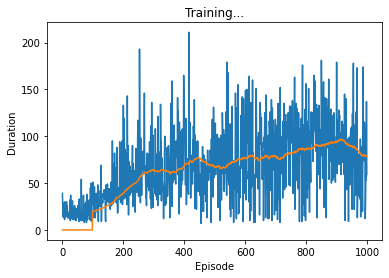

Episode 1000 
 100 episode moving avg: 78.73


In [19]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
lr = 0.001
memory_size = 100000
target_update = 10
num_episodes = 1000


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start,eps_end,eps_decay)
agent =Agent(strategy,em.num_actions_available(),device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(),em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(),em.get_screen_width()).to(device)


target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer=optim.Adam(params=policy_net.parameters(),lr=lr)

episode_durations=[]
for episode in range(num_episodes):
    em.reset()
    state=em.get_state()
    for timestep in count():
        action= agent.select_action(state,policy_net)
        reward = em.take_action(action)
        next_state=em.get_state()
        memory.push(Experience(state,action,next_state,reward))
        state= next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states,actions,rewards,next_states = extract_tensors(experiences)
            
            current_q_values = Qvalues.get_current(policy_net,states,actions)
            next_q_values = Qvalues.get_next(target_net,next_states)
            target_q_values = (gamma * next_q_values) + rewards
            
            loss=F.mse_loss(current_q_values,target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations,100)
            break
        
    if episode%target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()